In [1]:
import os
import collections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sweetviz as sv

from seaborn_analyzer import CustomPairPlot
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, chi2
from sklearn.feature_selection import VarianceThreshold

from tqdm import tqdm
from IPython.display import HTML


import config

# 最大表示列数の指定（ここでは50列を指定）
pd.set_option("display.max_columns", 50)
pd.set_option("display.max_rows", 50)
pd.set_option("display.width", 2000)

In [2]:
def make_dir(dir_name: str):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

# 各遺伝子データの読み込み

In [16]:
df_cna = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_cna.txt", index_col=0).T
df_cna = df_cna.drop(df_cna.index[0])

df_methylation_promoters_rrbs = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_methylation_promoters_rrbs.txt", index_col=0
).T

df_mrna_agilent_microarray_zscores_ref_all_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_all_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_all_samples = (
    df_mrna_agilent_microarray_zscores_ref_all_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray_zscores_ref_diploid_samples = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR
    + "/data_mrna_agilent_microarray_zscores_ref_diploid_samples.txt",
    index_col=0,
).T
df_mrna_agilent_microarray_zscores_ref_diploid_samples = (
    df_mrna_agilent_microarray_zscores_ref_diploid_samples.drop("Entrez_Gene_Id")
)

df_mrna_agilent_microarray = pd.read_table(
    config.RAW_BRCA_METABRIC_DIR + "/data_mrna_agilent_microarray.txt", index_col=0
).T
df_mrna_agilent_microarray = df_mrna_agilent_microarray.drop("Entrez_Gene_Id")

# 　ファイルの中身が壊れているため、使用するなら要修正
# df_mutations = pd.read_table(config.RAW_BRCA_METABRIC_DIR + "/data_mutations.txt").T


# 各dfの中身変更防止の為setを仕様
df_set = (
    df_cna,
    df_methylation_promoters_rrbs,
    df_mrna_agilent_microarray_zscores_ref_all_samples,
    df_mrna_agilent_microarray_zscores_ref_diploid_samples,
    df_mrna_agilent_microarray,
    # df_mutations
)
df_name_set = (
    "df_cna",
    "df_methylation_promoters_rrbs",
    "df_mrna_agilent_microarray_zscores_ref_all_samples",
    "df_mrna_agilent_microarray",
    # "df_mutations"
)

## 特徴量が重複していないか確認
遺伝子名が数多く存在するので、特徴量の名前に重複がないか確認する。

In [4]:
for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の重複columns", "*****" * 5)
    for k, v in collections.Counter(df.columns.tolist()).items():
        if v > 1:
            print(k)

************************* df_cna の重複columns *************************
PALM2AKAP2
************************* df_methylation_promoters_rrbs の重複columns *************************
************************* df_mrna_agilent_microarray_zscores_ref_all_samples の重複columns *************************
HERC2P9
RPL7A
RBMY1F
MUC3A
TP53TG3D
RDH5
TRDV2
NIPAL1
PCDHA@
SMG1P5
RIOK3
SRR
BOLA2
CEP170
SPAG8
GNG10
PPM1H
NSUN5
IGLL1
CBWD1
FCGR1A
MAGED4B
LINC00965
RPL36
ILKAP
CD24
HLA-DRB4
SLC25A37
DYNLRB1
LINC00937
BMS1P21
PLAGL1
RPAIN
LSP1
MRPL23
LINC01089
DMRTC1B
LINC00869
RPL13A
RPL5
OTUD7A
SBDS
INTS4
SRGAP2
MS4A18
PIN4
XG
PCSK6
CORT
CEP164
RPL37
AFAP1
FAM163B
CLK2
BMS1
SNRPN
BIRC5
IGSF9B
RPL4
CTTNBP2NL
WASH3P
LINC01128
BMS1P4
PMS2P1
MZT2A
RFFL
P2RX5
FAM153A
CYP2D6
SLX1A
NBPF1
AIDA
OR1D5
MRPL45P2
CSPG4P5
FAM230A
PPT2
DDX17
NME1
RPL39
RPL13
LIMS3
CES5A
TSPY1
NNT
DND1
GOLGA6L5P
MT1E
STAG3
DEPDC4
YWHAE
TNRC18
UBE2V1
OPLAH
PDE4C
ARHGEF10
RPL23AP82
FAM182A
NOP56
CT47A1
ARID1B
C4orf50
KIF5C
CCT6A
CCDC57
SUMO1
KCTD5


In [5]:
# shapeの確認
print(df_name_set)
print([df.shape for df in df_set])

('df_cna', 'df_methylation_promoters_rrbs', 'df_mrna_agilent_microarray_zscores_ref_all_samples', 'df_mrna_agilent_microarray')
[(2173, 22544), (1418, 13188), (1904, 24368), (1905, 24368)]


In [6]:
# total null num

for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の合計null数", "*****" * 5)
    print(df.isnull().sum().sum())
    print("*****" * 5, df_name, "の各columnsのnullの数", "*****" * 5)
    print(df.isnull().sum().sort_values(ascending=False).head(467))

************************* df_cna の合計null数 *************************
2356
************************* df_cna の各columnsのnullの数 *************************
Hugo_Symbol
LCE3C       41
GSTT1       35
GSTM1       31
HLA-DRB5    29
TAS2R43     29
            ..
PRR20C       1
POU5F1B      1
NEUROG2      1
PLIN1        0
PMVK         0
Length: 467, dtype: int64
************************* df_methylation_promoters_rrbs の合計null数 *************************
555316
************************* df_methylation_promoters_rrbs の各columnsのnullの数 *************************
Hugo_Symbol
CUL5        432
PHYHD1      427
ANKRD6      427
MIR1193     426
TTC39A      426
           ... 
GRM2        267
TMEM132C    267
PTPMT1      267
HN1L        267
MBTPS1      267
Length: 467, dtype: int64
************************* df_mrna_agilent_microarray_zscores_ref_all_samples の合計null数 *************************
10
************************* df_mrna_agilent_microarray_zscores_ref_all_samples の各columnsのnullの数 *************************
Hu

In [7]:
# Finding missing data and the percentage of it in each column

for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "の各columnsのnullの全体データ数に対する割合", "*****" * 5)
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat(
        [total, percent], axis=1, keys=["Total_NaN", "Percent_Nan"]
    )
    display(missing_data.head())

************************* df_cna の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
LCE3C               41     0.018868
GSTT1               35     0.016107
GSTM1               31     0.014266
HLA-DRB5            29     0.013346
TAS2R43             29     0.013346

************************* df_methylation_promoters_rrbs の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
CUL5               432     0.304654
PHYHD1             427     0.301128
ANKRD6             427     0.301128
MIR1193            426     0.300423
TTC39A             426     0.300423

************************* df_mrna_agilent_microarray_zscores_ref_all_samples の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
SLC25A19             2     0.001050
CSNK2A1              2     0.001050
FAM71A               1     0.000525
TMPRSS7              1     0.000525
MRPL24               1     0.000525

************************* df_mrna_agilent_microarray の各columnsのnullの全体データ数に対する割合 *************************


Total_NaN  Percent_Nan
Hugo_Symbol                        
SLC25A19             2     0.001050
AK127905             2     0.001050
CSNK2A1              2     0.001050
CX758427             1     0.000525
SNORD100             1     0.000525

************************* df_cna のnull数の可視化 *************************


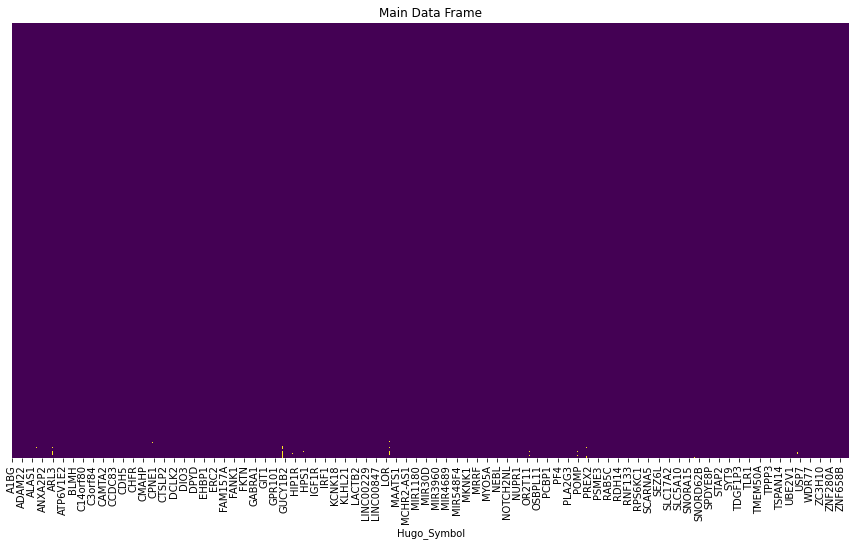

************************* df_methylation_promoters_rrbs のnull数の可視化 *************************


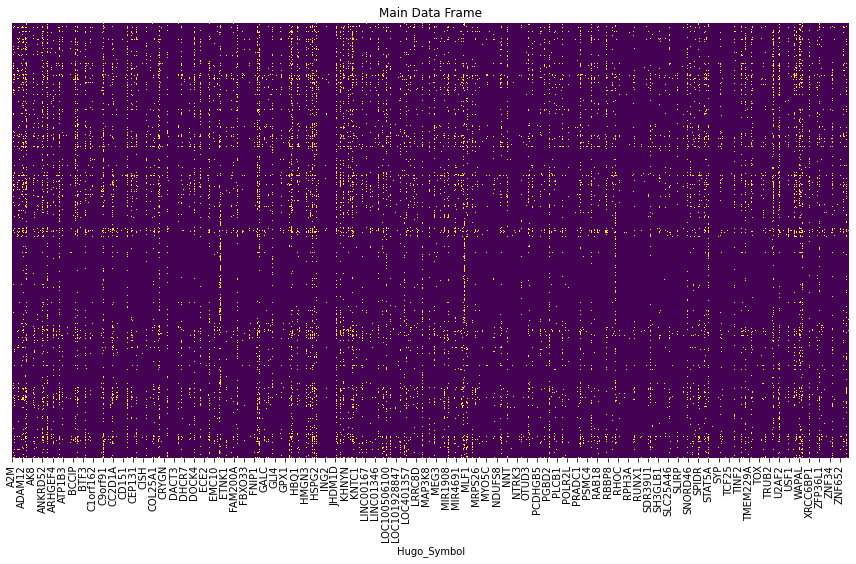

************************* df_mrna_agilent_microarray_zscores_ref_all_samples のnull数の可視化 *************************


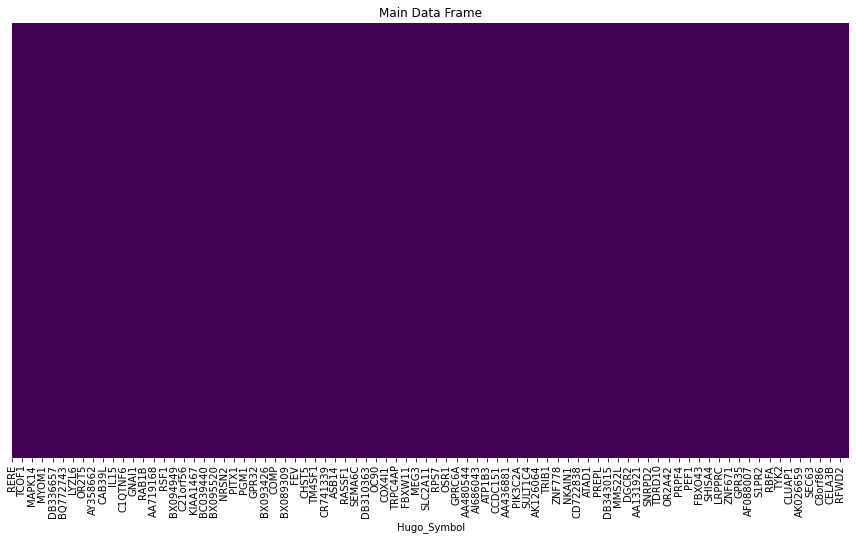

************************* df_mrna_agilent_microarray のnull数の可視化 *************************


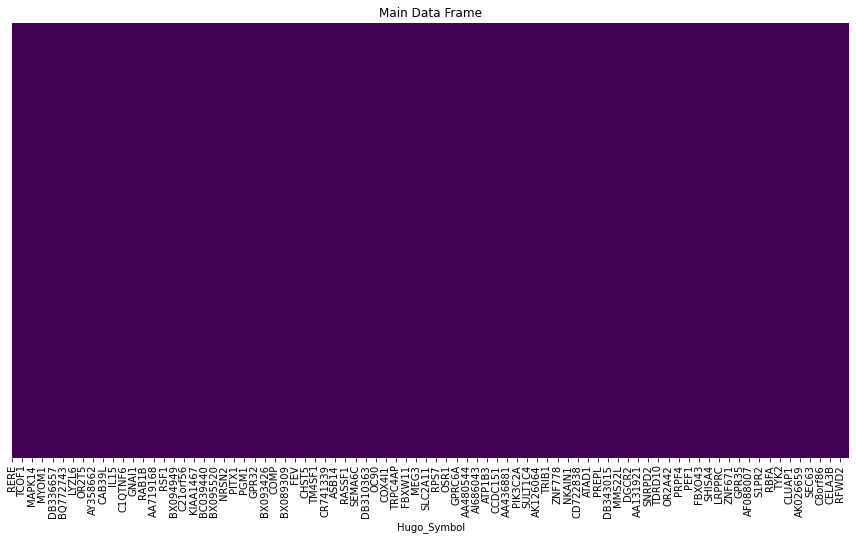

In [8]:
# Visualization of missing data
%matplotlib inline


for df, df_name in zip(df_set, df_name_set):
    print("*****" * 5, df_name, "のnull数の可視化", "*****" * 5)
    fig, ax = plt.subplots(figsize=(15, 8))
    sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap="viridis")
    ax.set_title("Main Data Frame")
    plt.show();

## indexと対応させるために読み込み

### 目的変数の生成

元のdfにはない目的変数カラム（5年後の生存の有無）を生成する。

#### 目的変数｜5年後の予後の2値分類
5年後の予後を2値分類する。  
そのためにVITAL_STATUSとOS_MONTHを利用する。  
以下のフローチャートで生成する。  

In [9]:
HTML(
    '<div class="mxgraph" style="max-width:100%;border:1px solid transparent;" data-mxgraph="{&quot;highlight&quot;:&quot;#0000ff&quot;,&quot;nav&quot;:true,&quot;resize&quot;:true,&quot;toolbar&quot;:&quot;zoom layers tags lightbox&quot;,&quot;edit&quot;:&quot;_blank&quot;,&quot;xml&quot;:&quot;&lt;mxfile host=\&quot;Electron\&quot; modified=\&quot;2022-05-01T07:33:42.0.405Z\&quot; agent=\&quot;5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) draw.io/17.2.0.2 Chrome/100.0.4896.60 Electron/18.0.1 Safari/537.36\&quot; etag=\&quot;CUa6MuG2A-EYqdbBh0ys\&quot; version=\&quot;17.2.0.2\&quot; type=\&quot;device\&quot;&gt;&lt;diagram id=\&quot;C5RBs43oDa-KdzZeNtuy\&quot; name=\&quot;Page-1\&quot;&gt;7VhZc5swEP41TJ7a4Yix/RjbcZI2SduBJNOnjAIyqBasK4SP/vpKQTIQXB9tncMTP3jYZVlJ+317gOH0k/kZQ5P4CkJMDdsM54YzMGy7ZZniXyoWhcLtOoUiYiQsVFap8MgvrJTquSgnIc5qhhyAcjKpKwNIUxzwmg4xBrO62QhofdUJinBD4QWINrV3JORxoe3Y7VJ/jkkU65Utt1vcSZA2VifJYhTCrKJyTg2nzwB4cZXM+5jK2Om43F0s7ujl2D379C37iW56n/3r2w+Fs+EujyyPwHDK/69ru3A9RTRX8VJn5QsdQAZ5GmLpxDScXswTKi4tcfkDc75QgKOcg1AB4zFEkCJ6CTBRdiNIuTKzpIzT8EQCK+QHCsG4UA0JpWoNISn7jpAyzmC8xE46WAIhjSl6wLSHgnH0uNE+UGDiVgoplq5CQQZ1lnJzp6W2t2VsFQYZ5CzAa+xUcnDEIrzOn1vYyf1VeKqQO8OQYM4WwoBhijiZ1smMVE5ES7sSd3GhoN+BBk6DBuHIaPVuL/yTy3vPP/FvPMMWrs0v3v3Vl2v/3DNagzVMkSjNYsKxN0GP4ZqJ2lJnT5UV4uC9iKIsU5hugHw3yKaYcTxfG2R911WZrkpdR4mzsm5YuhjElZpxbO4JluMGLN9FKX1P0H9JUHfLBNX9a2OGKrJoYmydsMrTVyDiXKUJjEaZ2NhT6iwX/Hs2tRpsuoYGmTbj8abp9kJkau/GJevVc8ltcKnsDDITXJTIek+5jLm8b+raWi1cMSQPeba5V9QAlvQZooRQGaxzTKeYkwCt6CiIkigVQiCwxmw1c8SSJI2E5JaS/8hUUXz32Gna9U6zlKutxlzRajr7ajXt1ROAYrZs9maB4xDRDB9c63fsJ4B0X7r3d7ap1m+6Fj9769dldXPvt7as14o95kdH/GoEev3jQHer4fJ9HtgPw+xDmwj0Dit8qr8+qv5xNCCCLLYJI/E3IBlGGT56Hw3+OBrYqzrRs44GuhpWZwMmAnFoM8DT1/9j56VnAF0lNk9lPssPfyhzrP0BIsTyS25RE8vP4c7pbw==&lt;/diagram&gt;&lt;/mxfile&gt;&quot;}"></div><script type="text/javascript" src="https://viewer.diagrams.net/js/viewer-static.min.js"></script>'
)

In [10]:
df_MB = pd.read_pickle(config.INTERIM_PICKLE_EDA_DIR + "/df_MB.pkl")

df_MB["target_OS_5years"] = np.nan
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    df_MB["OS_MONTHS"] > 60, False
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].mask(
    (df_MB["OS_MONTHS"] <= 60) & (df_MB["VITAL_STATUS"] == "Died of Disease"),
    True,
)
df_MB["target_OS_5years"] = df_MB["target_OS_5years"].astype(bool)
# targetを定義できなかったデータは除く
# df_MB = df_MB[df_MB["target_OS_5years"].notnull()]

# 治療クラスの値変更
df_MB["HORMONE_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["RADIO_THERAPY"].replace({"YES": 1, "NO": 0}, inplace=True)
df_MB["BREAST_SURGERY"].replace({"BREAST CONSERVING": 1, "MASTECTOMY": 0}, inplace=True)

# 目的変数生成で使用した特徴量を削除
df_MB.drop(["OS_MONTHS", "OS_STATUS", "VITAL_STATUS"], axis=1, inplace=True)

# df_mrna_agilent_microarrayについてEDA

In [17]:
df_mrna_agilent_microarray.head()

Hugo_Symbol      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN     SLC9A1       PML  CR749394     CD164  DB337918   MOBKL2A  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4   ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
MB-0362      8.676978  6.075331  5.453928  4.994525  5.838270   6.397503  7.906217  5.259461  5.702379  6.930741  5.332863  5.275676  5.443896  5.391825  5.332039  6.654909  6.116269  5.502459  6.170848  10.014262  6.223714  5.282517  5.453830  5.393823  6.781114  ...  5.345515   5.289049  6.642358  5.384824   5.624982  5.244877  8.245886  11.179554  6.108972  9.144958  5.172836  5.623032  5.548618  5.335488  5.309543  5.271343  5.680321  7.688492  8.084979  5.161796  6.353215  4.836483  7.304643  5.251843  5.049591
MB-0346      9.653589  6.687887  5.454185  5.346010  5.600876   5.246319  8.267256  5.380069  5.521794  6.141689  7.563477  5.376381  5.319857  5.493960  4.974668  6.546139  5.496121  5.396100  6.462099   9.348527  5.771658  5.312611  5.856599  5.038963  6.932299  ...  5.469792   5.614731  6.305837  5.835178   5.372428  5.174309  7.636559   9.593976  6.708027  7.387434  5.468569  5.482444  5.451468  5.471839  5.579198  5.942887  5.461069  7.804165  8.349115  5.197392  6.132355  5.316819  7.933324  5.450611  5.316790
MB-0386      9.033589  5.910885  5.501577  5.247467  6.030718  10.111816  7.959291  5.262024  5.689533  6.529312  5.482155  5.463788  5.254294  5.405767  5.306545  6.290807  6.202997  5.166248  5.881027   8.811785  6.532682  5.436369  5.381199  5.451264  6.671176  ...  5.314732   5.173775  5.937808  5.676467   5.541437  5.261631  8.105658  11.108679  6.977441  9.030003  5.235995  5.641355  5.762705  5.322604  5.484665  5.174498  5.304030  7.934309  8.406332  8.087722  6.366335  5.466419  7.580336  5.235394  5.461617
MB-0574      8.814855  5.628740  5.471941  5.316523  5.849428   6.116868  9.206376  5.396576  5.439130  6.430102  5.398675  5.409761  5.512298  5.452995  5.409993  6.270448  5.882995  5.314793  6.059837   8.952057  6.113587  5.539569  5.897422  5.602036  6.708135  ...  5.294164   5.420128  6.413538  5.457784   5.438267  5.126400  7.992744  10.642113  6.999086  7.219965  5.655266  5.966010  5.792747  5.520733  5.419803  5.116749  5.632249  7.744562  8.310019  5.780062  6.424048  5.193150  6.903654  5.091927  5.227130
MB-0503      9.274265  5.908698  5.531743  5.244094  5.964661   7.828171  8.706646  5.167213  5.417484  6.684893  5.266674  5.490693  5.363378  5.635478  5.376543  6.575093  5.766303  5.303814  6.427345   9.294008  6.218404  5.121197  5.424916  5.536605  6.972232  ...  5.129111   5.388149  6.773850  6.146829   5.334199  5.400822  8.053461  10.114433  6.283907  8.751008  5.425088  5.838210  5.396735  5.492591  5.324644  5.402314  5.472185  7.701394  8.137014  5.498185  6.214301  5.274600  6.839417  5.315224  5.027476

[5 rows x 24368 columns]

### df_MBの読み込み

df_MB（patient_idと目的変数のみ）とdf_cnaをpatient_id（Hugo_Symbol：reset_indexによってindexがHugo_Symbolとなっている）をキーとして結合

In [18]:
df_MB_genes = pd.merge(
    df_MB[
        [
            "PATIENT_ID",
            "target_OS_5years",
            # "HORMONE_THERAPY",
            # "RADIO_THERAPY",
            # "BREAST_SURGERY",
        ]
    ],
    df_mrna_agilent_microarray.reset_index(),
    right_on="index",
    left_on="PATIENT_ID",
).drop("index", axis=1)

df_MB_genes = df_MB_genes.set_index("PATIENT_ID")

print(
    df_mrna_agilent_microarray.shape,
    df_MB.shape,
    df_MB_genes.shape,
    df_MB_genes[df_MB_genes.target_OS_5years != np.nan].shape,
)

df_MB_genes.head()

(1904, 24368) (1985, 34) (1904, 24369) (1904, 24369)


target_OS_5years      RERE    RNF165  CD049690  BC033982      PHF7      CIDEA     PAPD4  AI082173   SLC17A3       SDS  ATP6V1C2        F3    FAM71C  AK055082  BU687559     LIN52     PCOTH      GRM1       FXN    SLC9A1       PML  CR749394     CD164  DB337918  ...   TMEM146  SLIT3-AS1   PSMC3IP     TEAD1  LOC253724  BM725158     GRHPR      EGLN2    TBC1D4   ANGPTL2  AF086457  AK124197     ENOX1  SBF2-AS1     VN1R4  BX115874  BX107598    UGCGL1     VPS72     CSMD3    CC2D1A  CB986545     IGSF9  DA110839    FAM71A
PATIENT_ID                                                                                                                                                                                                                                                                     ...                                                                                                                                                                                                                                                             
MB-0000                False  9.738092  6.469688  5.457135  5.106495  5.652674  11.558869  8.340484  5.384699  5.648494  5.336235  5.468668  7.070649  5.477154  5.489805  5.318898  6.811309  5.440853  5.361170  5.823306  8.809831  6.790593  5.595347  6.141047  5.481023  ...  5.353135   5.198876  5.901473  5.610397   5.515762  5.213511  8.139151  10.232505  7.311327  9.677952  5.318426  5.635153  5.918239  5.295203  5.474224  5.329883  5.745324  7.021679  8.010657  5.299815  6.235804  5.349555  5.947404  5.615147  5.133576
MB-0002                False  9.013876  5.748717  5.699735  5.419119  5.611212   6.199492  8.341091  5.490558  5.789506  5.700974  5.495295  6.098949  5.589824  5.055598  5.489397  6.952007  5.545206  5.579463  6.341935  9.307305  6.132436  5.328097  6.400910  5.531249  ...  4.888335   5.615278  6.447777  5.950548   5.502117  5.124030  8.261487  10.186566  6.324112  8.895600  5.345262  6.281727  5.515844  5.442257  5.303871  5.384794  5.285060  7.612797  7.988643  5.194247  6.328059  5.469445  6.938685  5.231857  5.604560
MB-0005                False  7.963493  5.553056  5.472386  5.265556  5.793398   6.489781  8.862815  5.538854  5.566713  7.233671  5.537530  6.964546  5.255454  5.374815  5.668776  6.480061  5.790445  5.462634  5.807004  8.477327  5.572601  5.539776  8.575001  5.562090  ...  5.313808   5.508167  6.076896  5.747801   5.368297  5.371385  7.731911   9.954702  7.222594  8.972083  5.420388  5.404494  5.350242  5.368716  5.370394  5.336455  5.452393  6.619220  8.044471  5.306294  6.306927  5.362207  7.397672  5.372138  5.645597
MB-0006                False  8.177157  5.391160  5.529795  5.011812  5.807604   5.319779  8.693784  5.430685  5.539252  6.124384  6.657355  6.409554  5.289307  5.299305  5.112324  5.987913  5.393475  5.282728  5.985588  8.101386  5.808433  5.345124  9.164529  5.336013  ...  5.228991   5.324400  5.650472  5.579526   5.303998  5.351482  8.301195  10.088769  7.053031  8.664307  5.370416  5.480761  5.650978  5.295628  5.694697  5.663304  5.529928  6.966482  7.527300  5.197607  6.515638  5.309927  6.175716  5.586521  5.354582
MB-0008                 True  8.050127  5.530582  5.303667  5.149618  5.934570   8.787583  8.055626  5.239388  5.646685  7.155642  5.878104  5.798117  5.297733  5.610297  5.141883  6.675580  6.598310  5.328773  6.200995  9.301414  6.182025  5.384272  5.904271  5.457066  ...  5.322069   5.136661  6.403137  5.904885   5.473140  5.460753  8.007261  11.244345  5.926732  8.141539  5.217030  5.442109  5.527755  5.192858  5.474929  5.799346  5.597297  6.942461  8.115359  5.254136  6.323751  5.518767  6.272568  5.204630  5.030636

[5 rows x 24369 columns]

In [19]:
# 目的変数の各カテゴリ（T/F）に属しているデータ数の差
df_MB_genes[df_MB_genes.target_OS_5years == True].shape, df_MB_genes[
    df_MB_genes.target_OS_5years == False
].shape

((472, 24369), (1432, 24369))

## 特徴量選択

特徴量選択手法によって、膨大な遺伝子の数を削減する  
- filter method
- wrapper method
- embedded method
の3つの手法がある

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

nullを含んでいるとできない手法もあるので、nullを削除する

In [28]:
print(df_MB_genes.shape, df_MB_genes.dropna().shape)
df_MB_genes.dropna(inplace=True)

(1904, 24369) (1894, 24369)


### 低分散変数の確認

分散が小さな特徴量を切り捨てる方法。今回は特徴量の値が全て同じものを切り捨てるために使用した（閾値（切り捨てたい分散の値）=0）。

In [29]:
sel = VarianceThreshold()
sel.fit_transform(df_MB_genes)

df_tmp = pd.DataFrame(
    sel.fit_transform(df_MB_genes),
    columns=df_MB_genes.columns.values[sel.get_support()],
)
print("Before Feature Selection:", df_MB_genes.shape)
print("After Feature Selection:", df_tmp.shape)

result = pd.DataFrame(
    sel.get_support(), index=df_MB_genes.columns.values, columns=["False: dropped"]
)
result["variance"] = sel.variances_
print(result)

Before Feature Selection: (1894, 24369)
After Feature Selection: (1894, 24369)
                  False: dropped  variance
target_OS_5years            True  0.186838
RERE                        True  0.248863
RNF165                      True  0.561938
CD049690                    True  0.018860
BC033982                    True  0.018509
...                          ...       ...
CC2D1A                      True  0.085417
CB986545                    True  0.019425
IGSF9                       True  0.488735
DA110839                    True  0.019254
FAM71A                      True  0.052879

[24369 rows x 2 columns]


In [30]:
# dropするべき特徴量の確認
result[result["False: dropped"] == False]

Empty DataFrame
Columns: [False: dropped, variance]
Index: []

### filter method
データセットのみに注目して実施する特徴量選択

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection  
https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#122-%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95

In [31]:
# 実際にはtrainデータに実施した内容をtestデータに適用するので、それに習いこのEDAノートブックでも同様の処理（trainデータに対しての特徴量選択の実施）を行う
X, y = df_MB_genes.drop("target_OS_5years", axis=1), df_MB_genes.target_OS_5years
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)

In [32]:
def transform_minmaxscaler(df: pd.DataFrame) -> pd.DataFrame:
    mm = MinMaxScaler()
    mm.fit(df)
    df_tmp = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df_tmp


def feature_selection(
    X: pd.DataFrame, y: pd.Series, feature_selecton_method
) -> pd.DataFrame:
    selector = SelectKBest(feature_selecton_method, k="all")
    # 特徴量選択の実施（fit）
    selector.fit(X, y)
    selector.transform(X),
    # 返り値のためのdf作成
    result = pd.DataFrame(
        selector.get_support(),
        index=X.columns.values,
        columns=["False: dropped"],
    )
    result["score"] = selector.scores_
    result["pvalue"] = selector.pvalues_
    return result

In [33]:
X_train = transform_minmaxscaler(X_train)

# χ^2検定
result_chi2 = feature_selection(X_train, y_train, chi2)

# ANOVA
result_f_classif = feature_selection(X_train, y_train, f_classif)

# 相互情報量評価
result_mic = feature_selection(X_train, y_train, mutual_info_classif)

In [34]:
result_chi2[result_chi2.pvalue < 0.05]

False: dropped      score    pvalue
FGFR4               True   3.969947  0.046319
CDCA5               True   4.820622  0.028121
FAM83D              True   5.715385  0.016817
MELK                True   4.082387  0.043332
AGTR1               True   5.399949  0.020137
...                  ...        ...       ...
WDR19               True   3.843649  0.049935
CLCA2               True   5.791004  0.016108
CBX2                True   9.121529  0.002526
RGS22               True   5.084681  0.024138
C1orf106            True  10.169576  0.001428

[70 rows x 3 columns]

In [35]:
result_f_classif[result_f_classif.pvalue < 0.05]

False: dropped      score        pvalue
RERE             True  17.762393  2.660956e-05
PHF7             True  43.157203  7.073533e-11
CIDEA            True   4.804115  2.855397e-02
PAPD4            True  11.603930  6.765326e-04
SDS              True   4.199520  4.061910e-02
...               ...        ...           ...
ELANE            True   9.729150  1.850207e-03
BCAT1            True  14.046838  1.854750e-04
EGLN2            True  26.701409  2.713164e-07
VPS72            True   8.280682  4.066928e-03
IGSF9            True  11.848067  5.940004e-04

[6602 rows x 3 columns]

In [36]:
result_mic.sort_values("score", ascending=False)

False: dropped     score pvalue
PPIL1               True  0.048667   None
ABHD14A             True  0.046228   None
IFT46               True  0.045199   None
BX098805            True  0.044989   None
VANGL1              True  0.044640   None
...                  ...       ...    ...
WARS                True  0.000000   None
WDR1                True  0.000000   None
AK129567            True  0.000000   None
NKPD1               True  0.000000   None
BC038576            True  0.000000   None

[24368 rows x 3 columns]

In [37]:
"""
入力:feature_selection()によって出力されたpd.Dataframe

出力：なし

内容：sortした後の特徴量選択結果の可視化グラフの表示
"""


def plot_selection_result(df_result: pd.DataFrame, show_p=False):
    pd.options.display.float_format = None

    # p値の表示の有無でレイアウト変更
    ncols = 3 if show_p else 2
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(40, 20))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)

    df_result = df_result.sort_values("score", ascending=True).copy()
    df_result["score"].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
    axes[0].invert_xaxis()
    axes[0].set_yticklabels([])
    axes[0].set_ylabel("")
    axes[0].grid(axis="x", linestyle="dotted")
    axes[0].set_title("Score")
    if show_p:
        df_result["pvalue"].plot.barh(ax=axes[1], color="green")
        axes[1].set_ylabel("")
        axes[1].grid(axis="x", linestyle="dotted")
        axes[1].set_title("pvalue")
    axes[-1].axis("tight")
    axes[-1].axis("off")
    axes[-1].table(
        cellText=df_result.round(2).values,  # roundしないと表が小さすぎる
        colLabels=df_result.columns,
        rowLabels=df_result.index,
        loc="center",
    )
    plt.show()

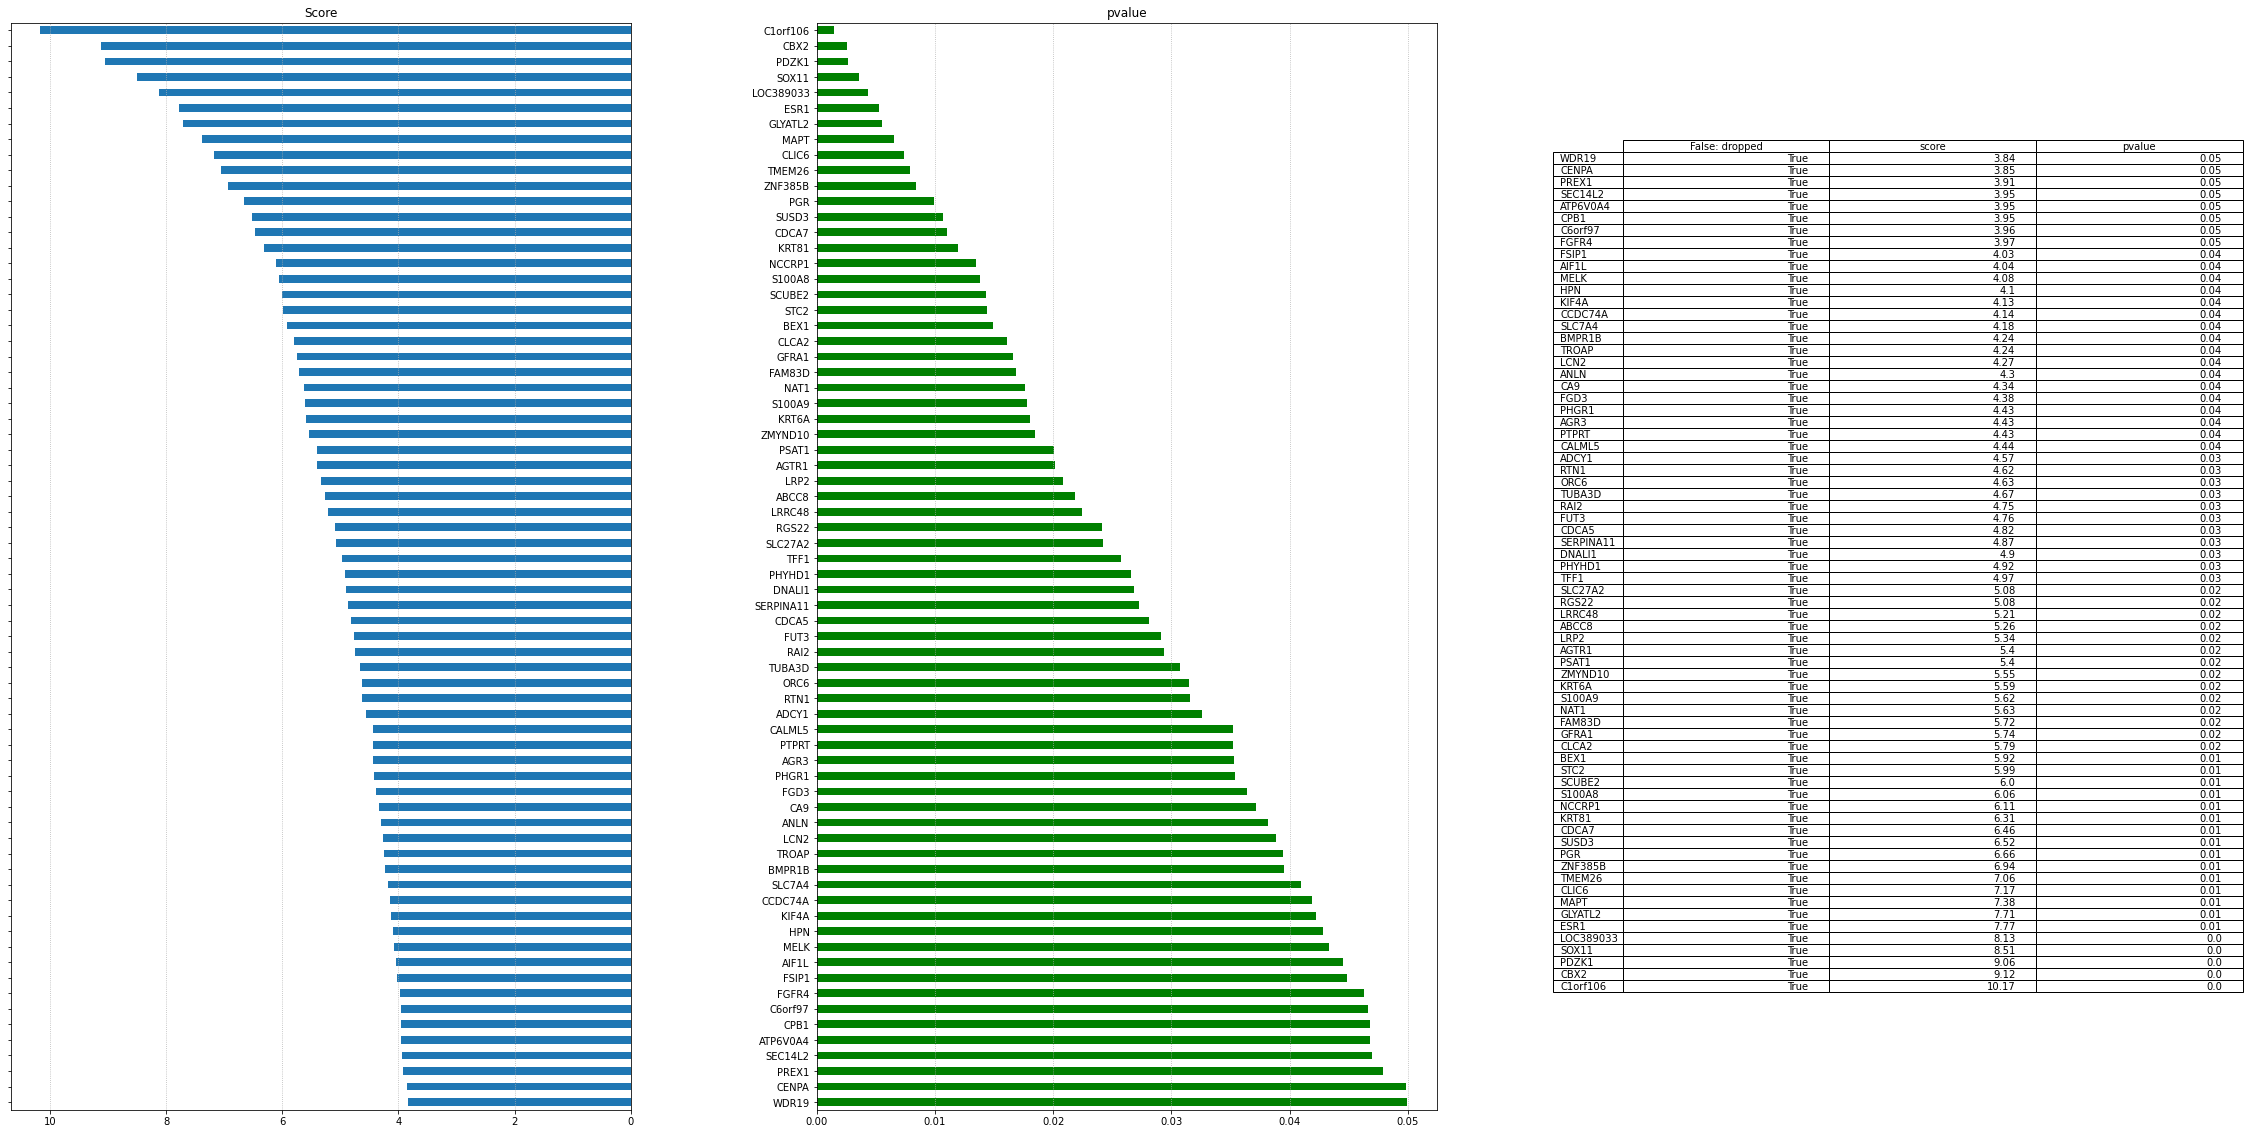

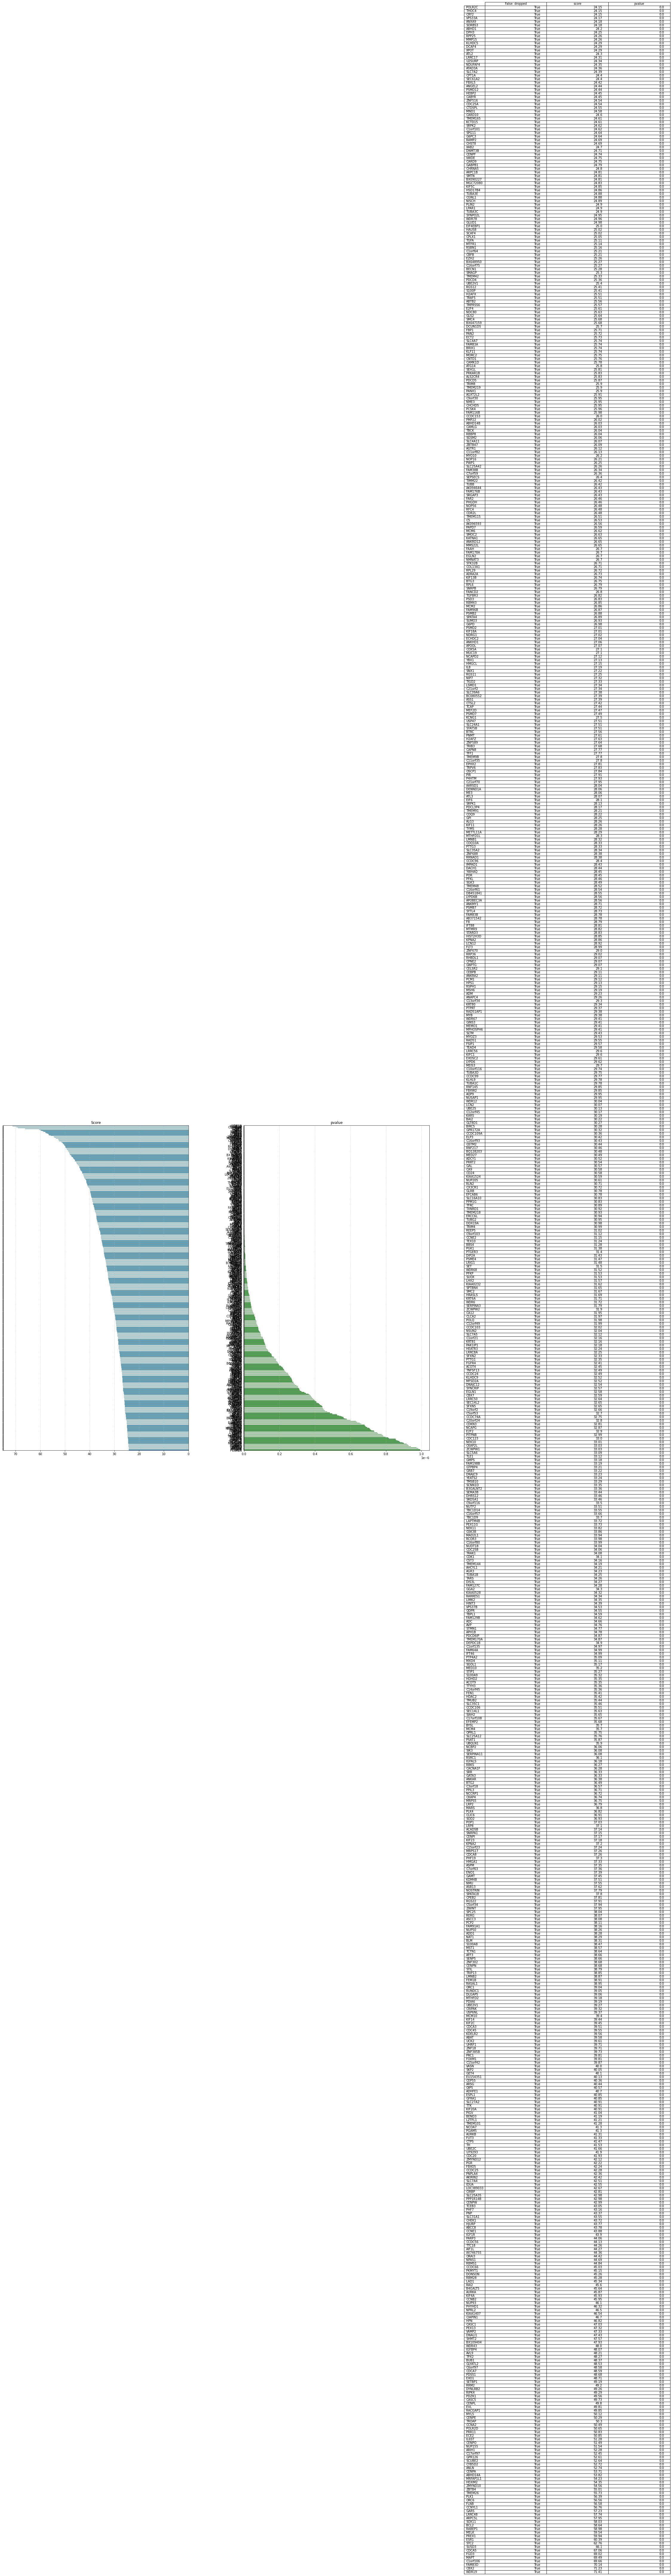

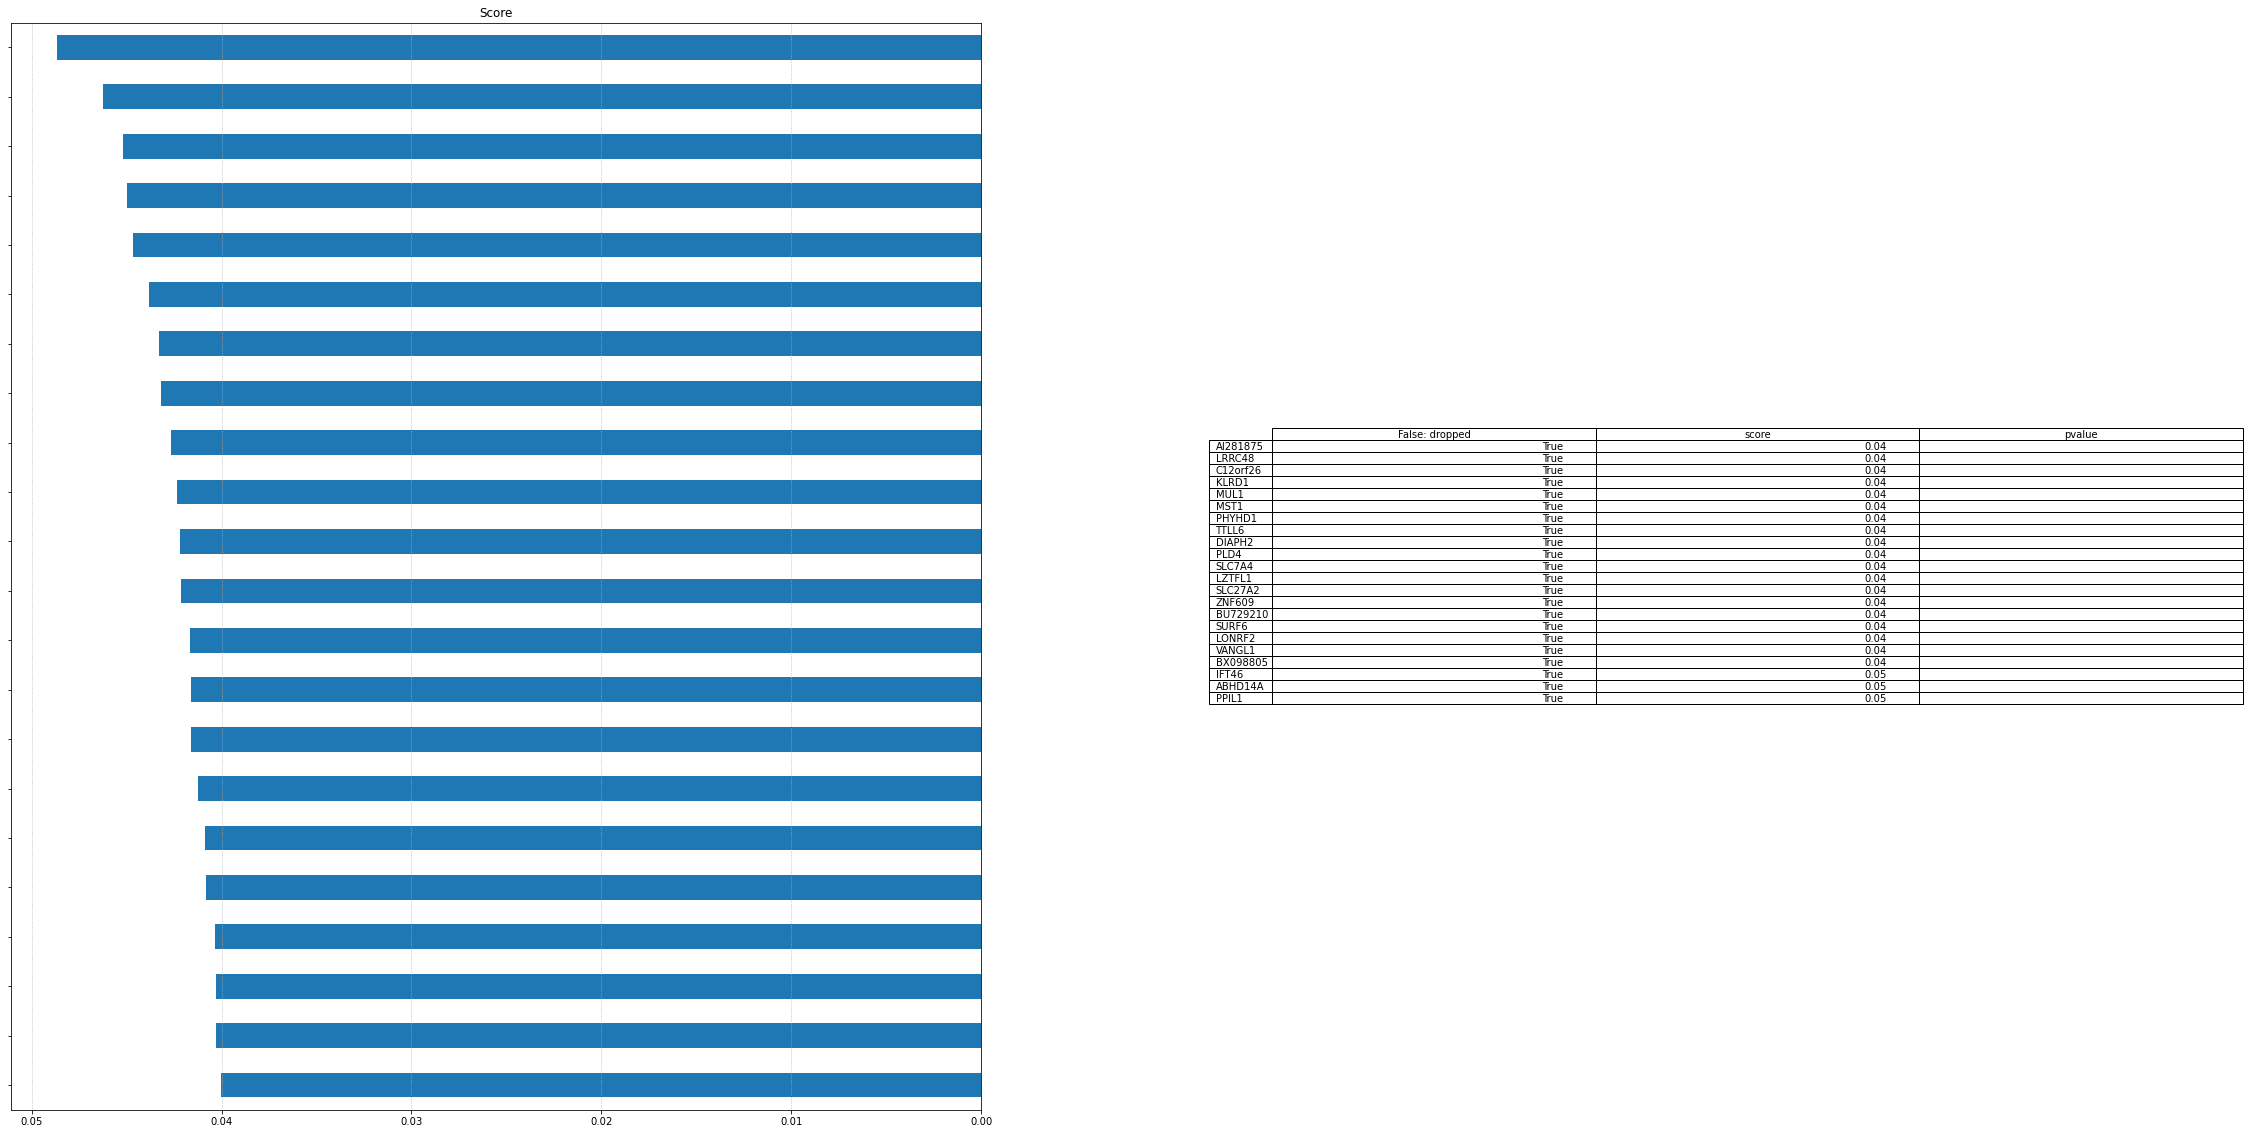

In [39]:
result_chi2 = feature_selection(X_train, y_train, chi2)

plot_selection_result(result_chi2[result_chi2.pvalue < 0.05], show_p=True)
plot_selection_result(result_f_classif[result_f_classif.pvalue < 0.000001], show_p=True)
plot_selection_result(result_mic[result_mic.score > 0.04])

# data_cnaについてEDA

patient_idをキーとしてmerge  
5年後の生存の有無と遺伝子情報を紐付ける

df_cnaを使うのは誤りでは（少なくとも優先度はz-scoreなどと比べると低い）？

### df_MBの読み込み

df_MB（patient_idと目的変数のみ）とdf_cnaをpatient_id（Hugo_Symbol：reset_indexによってindexがHugo_Symbolとなっている）をキーとして結合

In [160]:
df_MB_genes = pd.merge(
    df_MB[
        [
            "PATIENT_ID",
            "target_OS_5years",
            # "HORMONE_THERAPY",
            # "RADIO_THERAPY",
            # "BREAST_SURGERY",
        ]
    ],
    df_cna.reset_index(),
    right_on="index",
    left_on="PATIENT_ID",
).drop("index", axis=1)

df_MB_genes = df_MB_genes.set_index("PATIENT_ID")

print(
    df_cna.shape,
    df_MB.shape,
    df_MB_genes.shape,
    df_MB_genes[df_MB_genes.target_OS_5years != np.nan].shape,
)

df_MB_genes.head()

(2173, 22544) (1985, 34) (1985, 22545) (1985, 22545)


target_OS_5years  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  A4GNT  AAAS  AACS  AACSP1  AADAC  AADACL2  AADACL3  AADACL4  AADAT  AAED1  AAGAB  AAK1  AAMDC  AAMP  AANAT  ...  ZSCAN4  ZSCAN5A  ZSCAN5B  ZSCAN9  ZSWIM1  ZSWIM2  ZSWIM3  ZSWIM4  ZSWIM5  ZSWIM6  ZSWIM7  ZSWIM8  ZSWIM8-AS1  ZUFSP  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3
PATIENT_ID                                                                                                                                                                                                   ...                                                                                                                                                                                              
MB-0000                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0         0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0    0.0   0.0
MB-0002                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0  -1.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0   -1.0   0.0    1.0  -1.0   -1.0  ...     0.0      0.0      0.0    -1.0     1.0     0.0     1.0     0.0     0.0     0.0    -1.0    -1.0        -1.0   -1.0  -1.0    -1.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0   -1.0   0.0
MB-0005                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    1.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     1.0     0.0     1.0     1.0     0.0     0.0     0.0     0.0         0.0    0.0   1.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  2.0    0.0   0.0
MB-0006                False   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0    -1.0     0.0    -1.0     0.0     0.0     0.0     1.0     0.0         0.0    0.0   0.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  1.0    1.0   0.0
MB-0008                 True   0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0    -1.0     0.0    -1.0     0.0     0.0         0.0   -1.0  -1.0     0.0    0.0   0.0   0.0   1.0    -1.0    -1.0  0.0   -1.0   0.0

[5 rows x 22545 columns]

In [162]:
# 遺伝子のdfとdf_MBを結合したら、遺伝子のdfで見られないpatient_idがあったのでsortしてpatient_idの確認
# sortした結果、無事あったので、結合処理は大丈夫だろう
df_cna.sort_index().head()

Hugo_Symbol  A1BG  A1BG-AS1  A1CF  A2M  A2M-AS1  A2ML1  A2MP1  A3GALT2  A4GALT  A4GNT  AAAS  AACS  AACSP1  AADAC  AADACL2  AADACL3  AADACL4  AADAT  AAED1  AAGAB  AAK1  AAMDC  AAMP  AANAT  AAR2  ...  ZSCAN4  ZSCAN5A  ZSCAN5B  ZSCAN9  ZSWIM1  ZSWIM2  ZSWIM3  ZSWIM4  ZSWIM5  ZSWIM6  ZSWIM7  ZSWIM8  ZSWIM8-AS1  ZUFSP  ZW10  ZWILCH  ZWINT  ZXDA  ZXDB  ZXDC  ZYG11A  ZYG11B  ZYX  ZZEF1  ZZZ3
MB-0000       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    0.0   0.0    0.0   0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0         0.0    0.0   0.0     0.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0    0.0   0.0
MB-0002       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0  -1.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0   -1.0   0.0    1.0  -1.0   -1.0   0.0  ...     0.0      0.0      0.0    -1.0     1.0     0.0     1.0     0.0     0.0     0.0    -1.0    -1.0        -1.0   -1.0  -1.0    -1.0    0.0   0.0   0.0   0.0     0.0     0.0  0.0   -1.0   0.0
MB-0005       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0    0.0    0.0    0.0   0.0    1.0   0.0    0.0   1.0  ...     0.0      0.0      0.0     0.0     1.0     0.0     1.0     1.0     0.0     0.0     0.0     0.0         0.0    0.0   1.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  2.0    0.0   0.0
MB-0006       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0    -1.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0   1.0  ...     0.0      0.0      0.0     0.0    -1.0     0.0    -1.0     0.0     0.0     0.0     1.0     0.0         0.0    0.0   0.0     0.0    0.0   1.0   1.0   0.0     0.0     0.0  1.0    1.0   0.0
MB-0008       0.0       0.0   0.0  0.0      0.0    0.0    0.0      0.0     0.0    0.0   0.0   0.0     0.0    0.0      0.0      0.0      0.0   -1.0    0.0    0.0   0.0    0.0   0.0    0.0   0.0  ...     0.0      0.0      0.0     0.0     0.0     0.0     0.0    -1.0     0.0    -1.0     0.0     0.0         0.0   -1.0  -1.0     0.0    0.0   0.0   0.0   1.0    -1.0    -1.0  0.0   -1.0   0.0

[5 rows x 22544 columns]

In [163]:
# 目的変数の各カテゴリ（T/F）に属しているデータ数の差
df_MB_genes[df_MB_genes.target_OS_5years == True].shape, df_MB_genes[
    df_MB_genes.target_OS_5years == False
].shape

((495, 22545), (1490, 22545))

## 特徴量選択

特徴量選択手法によって、膨大な遺伝子の数を削減する  
- filter method
- wrapper method
- embedded method
の3つの手法がある

https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d

nullを含んでいるとできない手法もあるので、nullを削除する

In [164]:
df_MB_genes.shape, df_MB_genes.dropna().shape
df_MB_genes.dropna(inplace=True)

((1985, 22545), (1903, 22545))

### 低分散変数の確認

分散が小さな特徴量を切り捨てる方法。今回は特徴量の値が全て同じものを切り捨てるために使用した（閾値（切り捨てたい分散の値）=0）。

In [167]:
sel = VarianceThreshold()
sel.fit_transform(df_MB_genes)

df_tmp = pd.DataFrame(
    sel.fit_transform(df_MB_genes),
    columns=df_MB_genes.columns.values[sel.get_support()],
)
print("Before Feature Selection:", df_MB_genes.shape)
print("After Feature Selection:", df_tmp.shape)

result = pd.DataFrame(
    sel.get_support(), index=df_MB_genes.columns.values, columns=["False: dropped"]
)
result["variance"] = sel.variances_
print(result)

Before Feature Selection: (1903, 22545)
After Feature Selection: (1903, 22545)
                  False: dropped  variance
target_OS_5years            True  0.187039
A1BG                        True  0.264711
A1BG-AS1                    True  0.265249
A1CF                        True  0.200415
A2M                         True  0.272307
...                          ...       ...
ZYG11A                      True  0.292155
ZYG11B                      True  0.297476
ZYX                         True  0.295012
ZZEF1                       True  0.300793
ZZZ3                        True  0.245128

[22545 rows x 2 columns]


In [168]:
# dropするべき特徴量の確認
result[result["False: dropped"] == False]

Empty DataFrame
Columns: [False: dropped, variance]
Index: []

### filter method
データセットのみに注目して実施する特徴量選択

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.feature_selection  
https://qiita.com/FukuharaYohei/items/db88a8f4c4310afb5a0d#122-%E8%A9%95%E4%BE%A1%E6%96%B9%E6%B3%95

In [187]:
# 実際にはtrainデータに実施した内容をtestデータに適用するので、それに習いこのEDAノートブックでも同様の処理（trainデータに対しての特徴量選択の実施）を行う
X, y = df_MB_genes.drop("target_OS_5years", axis=1), df_MB_genes.target_OS_5years
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=config.SEED)

In [211]:
def transform_minmaxscaler(df: pd.DataFrame) -> pd.DataFrame:
    mm = MinMaxScaler()
    mm.fit(df)
    df_tmp = pd.DataFrame(
        mm.transform(df),
        index=df.index,
        columns=df.columns,
    )
    return df_tmp


def feature_selection(
    X: pd.DataFrame, y: pd.Series, feature_selecton_method
) -> pd.DataFrame:
    selector = SelectKBest(feature_selecton_method, k="all")
    # 特徴量選択の実施（fit）
    selector.fit(X, y)
    selector.transform(X),
    # 返り値のためのdf作成
    result = pd.DataFrame(
        selector.get_support(),
        index=X.columns.values,
        columns=["False: dropped"],
    )
    result["score"] = selector.scores_
    result["pvalue"] = selector.pvalues_
    return result

In [268]:
X_train = transform_minmaxscaler(X_train)

# χ^2検定
result_chi2 = feature_selection(X_train, y_train, chi2)

# ANOVA
result_f_classif = feature_selection(X_train, y_train, f_classif)

# 相互情報量評価
result_mic = feature_selection(X_train, y_train, mutual_info_classif)

In [279]:
result_chi2[result_chi2.pvalue < 0.05]

False: dropped     score    pvalue
AARSD1            True  4.924399  0.026480
ACBD4             True  5.842483  0.015644
ADAM11            True  5.914680  0.015015
AOC2              True  4.599974  0.031972
AOC3              True  4.599974  0.031972
...                ...       ...       ...
TUBG2             True  4.295642  0.038210
UBTF              True  5.560022  0.018375
VPS25             True  4.948119  0.026119
WNK4              True  4.948119  0.026119
WNT5A             True  4.808695  0.028316

[83 rows x 3 columns]

In [278]:
result_f_classif[result_f_classif.pvalue < 0.05]

False: dropped      score        pvalue
A1CF               True   4.333582  3.754564e-02
A2ML1              True   4.150579  4.180473e-02
A2MP1              True   3.899113  4.850440e-02
A3GALT2            True   4.256097  3.929049e-02
AADACL3            True   5.196417  2.278076e-02
...                 ...        ...           ...
ZSWIM6             True   7.664398  5.705061e-03
ZSWIM7             True  27.625055  1.696668e-07
ZWILCH             True   5.732714  1.678030e-02
ZYX                True   5.401018  2.026504e-02
ZZEF1              True  27.151511  2.157427e-07

[8456 rows x 3 columns]

In [227]:
result_mic.sort_values("score", ascending=False)

False: dropped     score pvalue
H2AFJ              True  0.053775   None
PITPNM3            True  0.053443   None
SFMBT1             True  0.048994   None
CDH9               True  0.047952   None
NABP2              True  0.047329   None
...                 ...       ...    ...
MGAT5B             True  0.000000   None
MGLL               True  0.000000   None
MGME1              True  0.000000   None
MGRN1              True  0.000000   None
ZZZ3               True  0.000000   None

[22544 rows x 3 columns]

In [256]:
"""
入力:feature_selection()によって出力されたpd.Dataframe

出力：なし

内容：sortした後の特徴量選択結果の可視化グラフの表示
"""


def plot_selection_result(df_result: pd.DataFrame, show_p=False):
    pd.options.display.float_format = None

    # p値の表示の有無でレイアウト変更
    ncols = 3 if show_p else 2
    fig, axes = plt.subplots(nrows=1, ncols=ncols, figsize=(40, 20))
    fig.subplots_adjust(wspace=0.3, hspace=0.2)

    df_result = df_result.sort_values("score", ascending=True).copy()
    df_result["score"].plot.barh(ax=axes[0], stacked=True, y=[0, 1])
    axes[0].invert_xaxis()
    axes[0].set_yticklabels([])
    axes[0].set_ylabel("")
    axes[0].grid(axis="x", linestyle="dotted")
    axes[0].set_title("Score")
    if show_p:
        df_result["pvalue"].plot.barh(ax=axes[1], color="green")
        axes[1].set_ylabel("")
        axes[1].grid(axis="x", linestyle="dotted")
        axes[1].set_title("pvalue")
    axes[-1].axis("tight")
    axes[-1].axis("off")
    axes[-1].table(
        cellText=df_result.round(2).values,  # roundしないと表が小さすぎる
        colLabels=df_result.columns,
        rowLabels=df_result.index,
        loc="center",
    )
    plt.show()

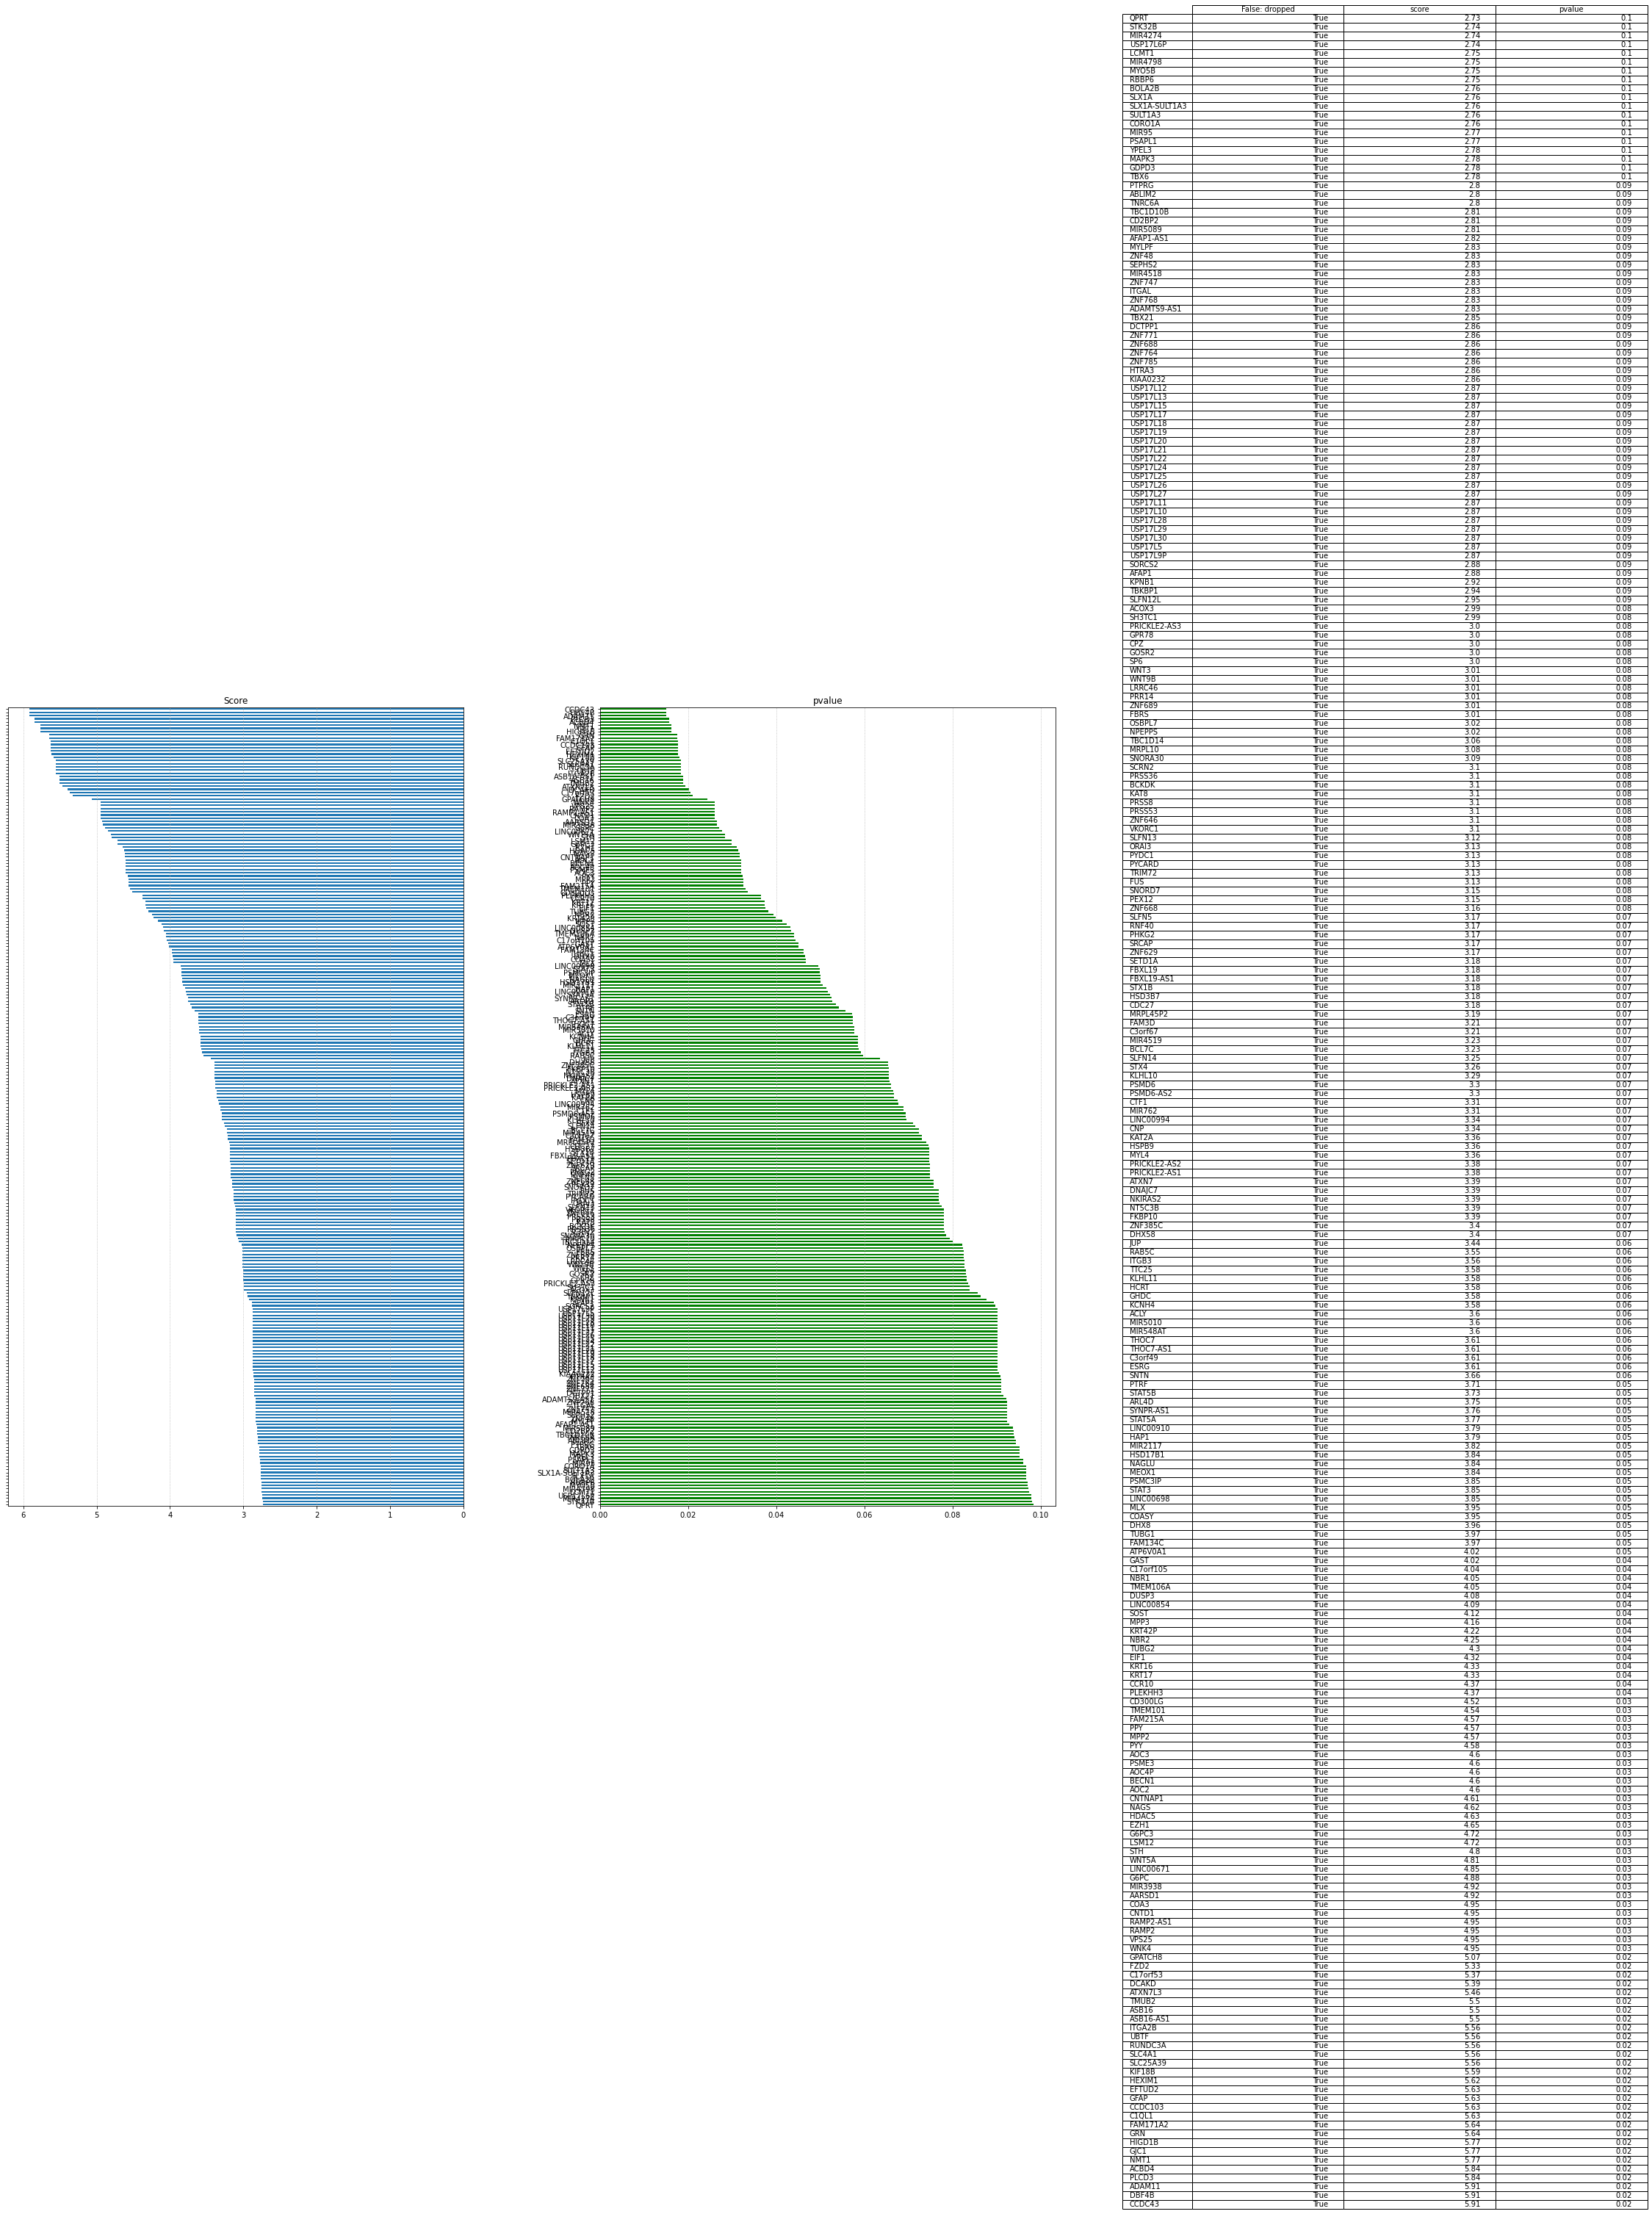

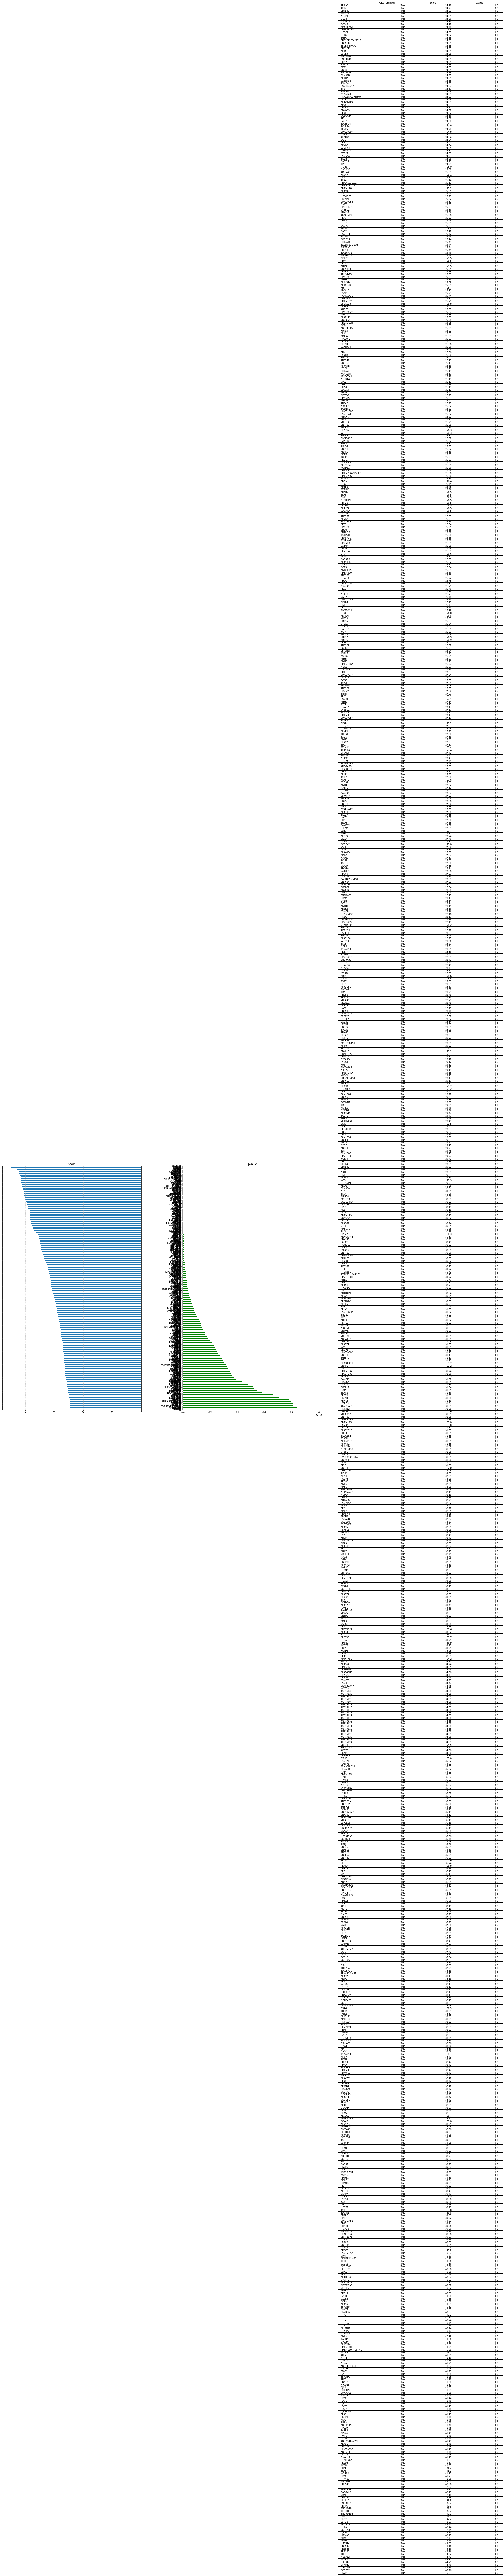

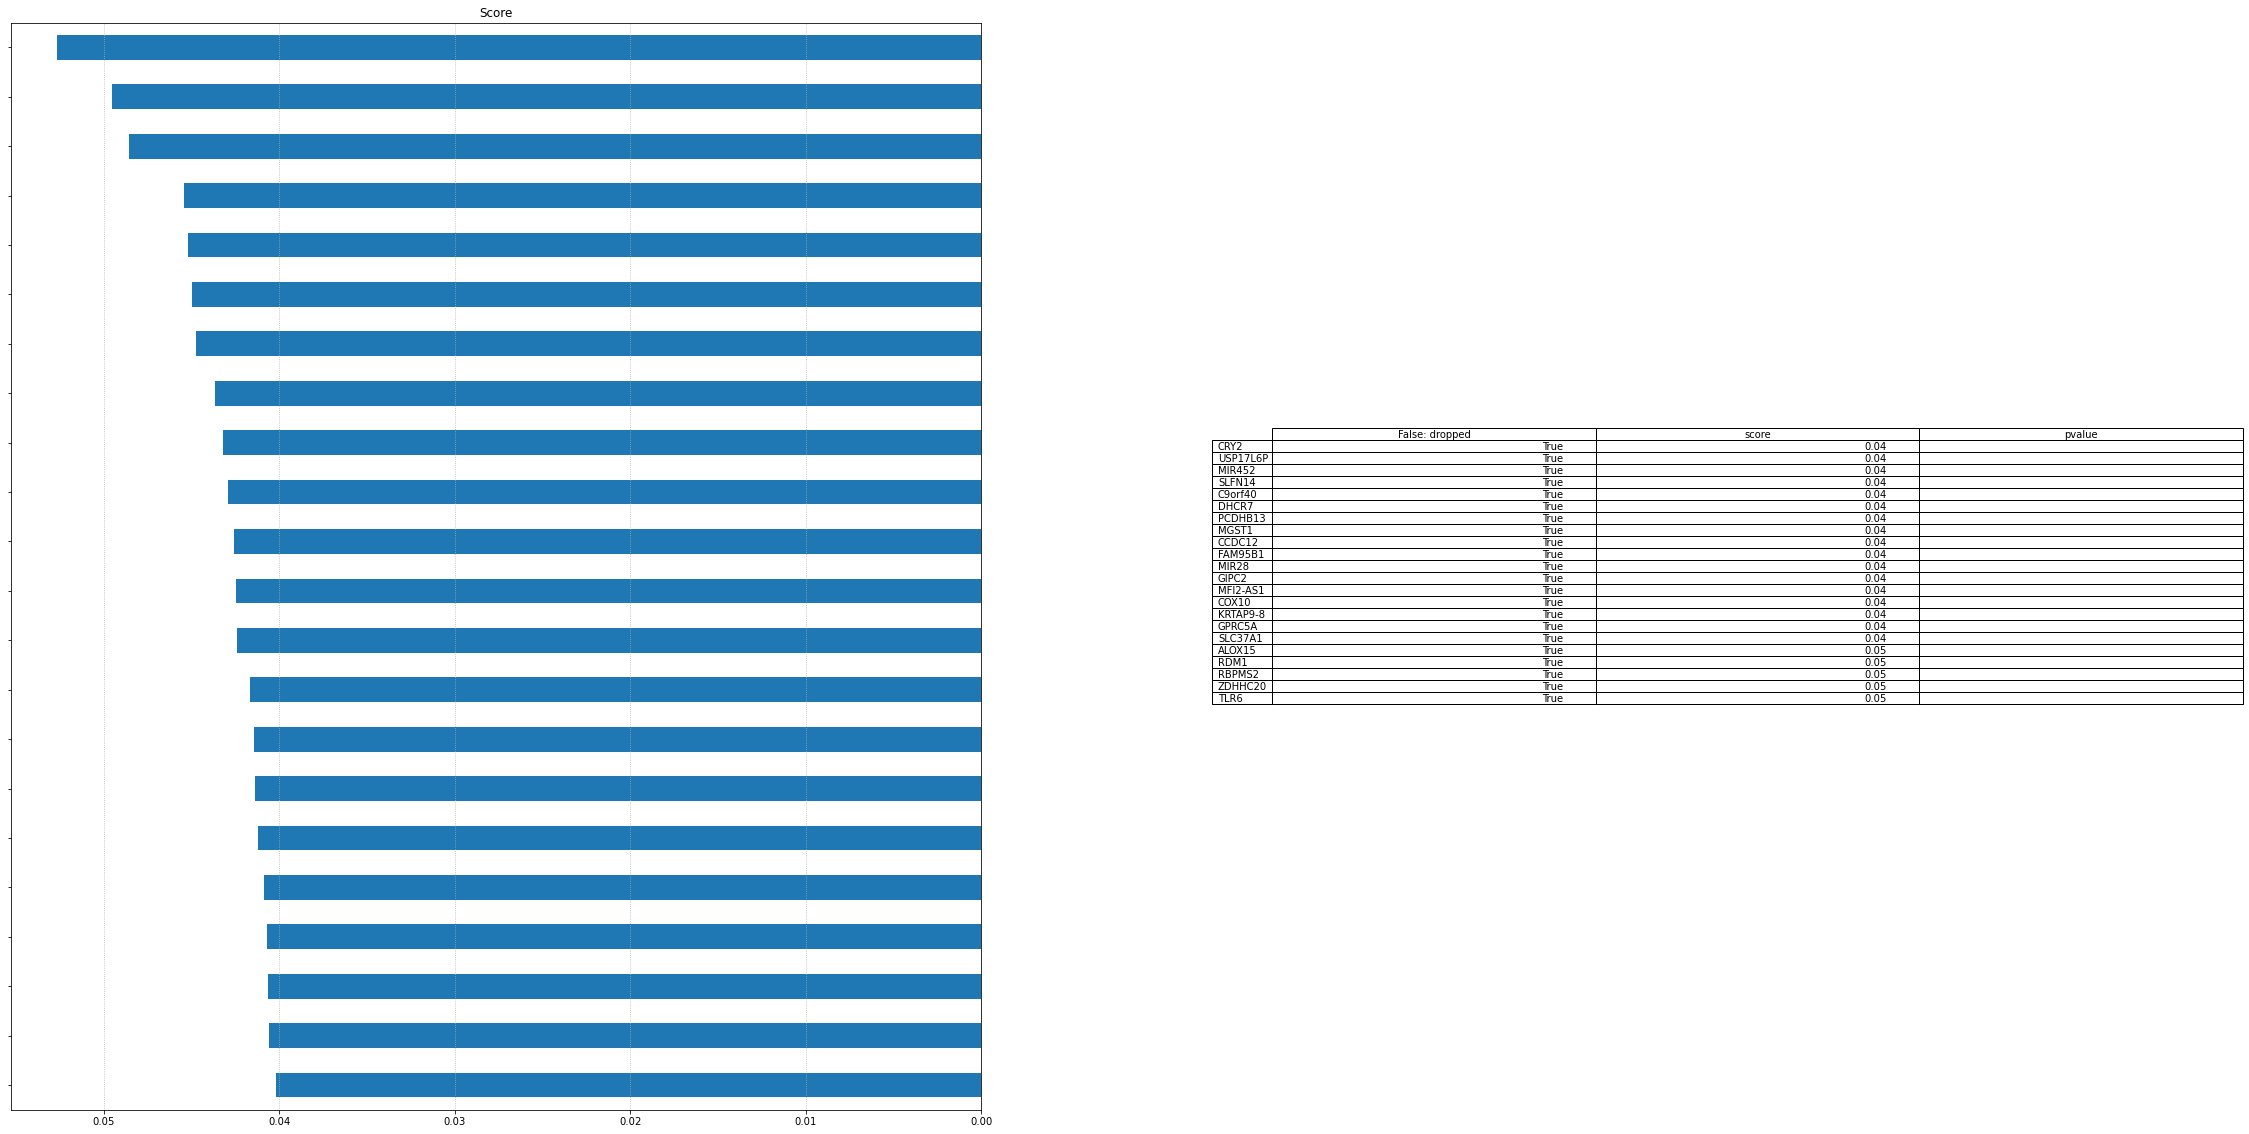

In [277]:
result_chi2 = feature_selection(X_train, y_train, chi2)

plot_selection_result(result_chi2[result_chi2.pvalue < 0.1], show_p=True)
plot_selection_result(result_f_classif[result_f_classif.pvalue < 0.000001], show_p=True)
plot_selection_result(result_mic[result_mic.score > 0.04])